## Assignment

In this assignment, you'll continue working with the house prices data. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the **houseprices** data from Thinkful's database.
* Reimplement your model from the previous checkpoint.
* Try OLS, Lasso, Ridge, and ElasticNet regression using the same model specification. This time, you need to do **k-fold cross-validation** to choose the best hyperparameter values for your models. Scikit-learn has RidgeCV, LassoCV, and ElasticNetCV that you can utilize to do this. Which model is the best? Why?


## Import Libraries 


In [1]:
#import libraries 


import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sqlalchemy import create_engine
from sklearn import linear_model
import statsmodels.api as sm

#new librarys for this assignment 
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


import warnings 

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

warnings.filterwarnings('ignore')



## Connect to database and Create Dataframe From Data

In [12]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

#create connection to database based on credentials 
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# create a dataframe from the imported data
house_price_data = pd.read_sql_query('select * from houseprices',con=engine)

#dispose of the connection 
engine.dispose()

## Create interaction variables 

In [13]:
house_price_data[['Gtl','Mod','Sev']] = pd.get_dummies(house_price_data.landslope)

#pd.get_dummies(house_price_data.landslope)
house_price_data.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,Gtl,Mod,Sev
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,1,0,0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500,1,0,0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,1,0,0
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000,1,0,0
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000,1,0,0


In [14]:
house_price_data['has_central_air'] =pd.get_dummies(house_price_data['centralair'], drop_first=True )

house_price_data['total_baths'] = house_price_data.fullbath + house_price_data.bsmtfullbath +.5*house_price_data.halfbath+.5*house_price_data.bsmthalfbath

house_price_data.head()


house_price_data['lotarea_GtlSlope']=house_price_data['lotarea']*house_price_data['Gtl']
house_price_data['lotarea_ModSlope']=house_price_data['lotarea']*house_price_data['Mod']
house_price_data['lotarea_SevSlope']=house_price_data['lotarea']*house_price_data['Sev']

## Set the parameters 

In [102]:
# Y is the target variable, in other words what are trying to predict.
Y = house_price_data['saleprice']

# X is the feature set we are using to predict the medical costs
X = house_price_data[['lotarea_GtlSlope','lotarea_ModSlope','lotarea_SevSlope','grlivarea','yearbuilt','garagearea','overallcond','total_baths']]



alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

## Seperate the Data Into Training and Test Sets

In [103]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.8, random_state = 24)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 292
The number of observations in test set is 1168


## Create Ordinary Least Squared regression 

In [104]:
V_train = sm.add_constant(X_train)

In [105]:
results = sm.OLS(Y_train, V_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     76.16
Date:                Tue, 28 Jan 2020   Prob (F-statistic):           4.30e-66
Time:                        21:07:07   Log-Likelihood:                -3545.8
No. Observations:                 292   AIC:                             7110.
Df Residuals:                     283   BIC:                             7143.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.744e+06   2.24e+05     -7.794      0.000   -2.18e+06    -1.3e+06
lotarea_GtlSlope    -0.0697      0.589     -0.118      0.906      -1.229       1.089
lotarea_ModSlope     1.0339      0.534      1.938      0.054      -0.016       2.084
lotarea_SevSlope     0.0392      0.810      0.048      0.961      -1.554       1.633
grlivarea           62.2541      6.700      9.291      0.000      49.065      75.443
yearbuilt          859.3556    113.546      7.568      0.000     635.854    1082.857
garagearea          98.0514     16.973      5.777      0.000      64.641     131.462
overallcond        1.27e+04   2394.938      5.305      0.000    7989.957    1.74e+04
total_baths       8741.9726   5236.152      1.670      0.096   -1564.775     1.9e+04
==============================================================================
Omnibus:                      102.200   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1660.636
Skew:                           0.941   Prob(JB):                         0.00
Kurtosis:                      14.530   Cond. No.                     9.25e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.25e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

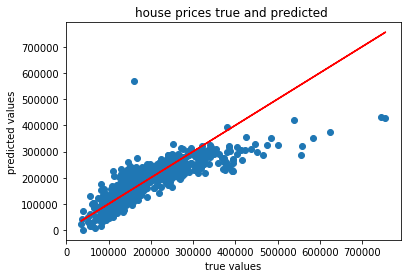

MAE = 28219.588783284067
MSE = 1869802228.0358326
RMSE = 43241.20983547792
MAPE = 16.303037254019678


In [106]:

V_test = sm.add_constant(X_test)



W_preds = results.predict(V_test)

plt.scatter(Y_test,W_preds)
plt.plot(W_test,W_test,color='red')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.title('house prices true and predicted ')
plt.show()

print ('MAE = {}'.format(mean_absolute_error(Y_test, W_preds)))
print ('MSE = {}'.format(mse(Y_test, W_preds)))
print ('RMSE = {}'.format(rmse(Y_test, W_preds)))
print ('MAPE = {}'.format(np.mean(np.abs((Y_test - W_preds)/Y_test))*100))



## Create Ridge Regression 

In [108]:
from sklearn.linear_model import RidgeCV

ridge_model = RidgeCV(alphas=alphas,cv=5)

ridge_model.fit(X_train, Y_train)

Y_train = ridge_model.predict(X_train)
Y_preds_test =  ridge_model.predict(X_test)


print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))




R-squared of the model on the training set is: 0.9948289776483387
-----Test set statistics-----
R-squared of the model on the test set is: 0.7120008048121592
Mean absolute error of the prediction is: 28012.25874099859
Mean squared error of the prediction is: 1869863142.9403372
Root mean squared error of the prediction is: 43241.91419144552
Mean absolute percentage error of the prediction is: 16.1443786338921


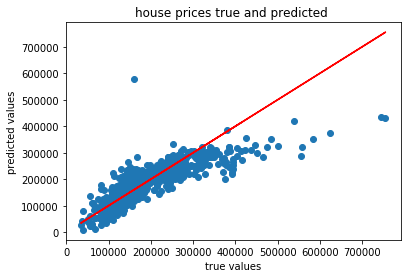

In [109]:
plt.scatter(Y_test,Y_preds_test)
plt.plot(Y_test,Y_test,color='red')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.title('house prices true and predicted ')
plt.show()


## LASSO regression


In [110]:
from sklearn.linear_model import LassoCV

lasso_model = LassoCV(alphas=alphas,cv=5)

lasso_model.fit(X_train, Y_train)

Y_train = lasso_model.predict(X_train)
Y_preds_test =  lasso_model.predict(X_test)


print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))



R-squared of the model on the training set is: 0.9948295019704034
-----Test set statistics-----
R-squared of the model on the test set is: 0.7120008048121592
Mean absolute error of the prediction is: 28012.122192485836
Mean squared error of the prediction is: 1869858634.5378368
Root mean squared error of the prediction is: 43241.86206140801
Mean absolute percentage error of the prediction is: 16.144251429916988


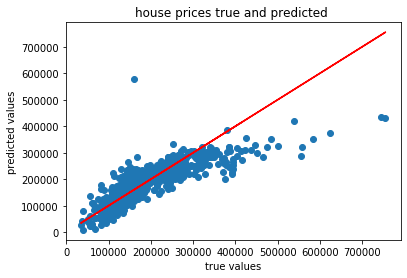

In [111]:
plt.scatter(Y_test,Y_preds_test)
plt.plot(Y_test,Y_test,color='red')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.title('house prices true and predicted ')
plt.show()


## Create an Elastinet Model

In [112]:
from sklearn.linear_model import ElasticNetCV

Elastanet_model = ElasticNetCV(alphas=alphas,cv=5)

Elastanet_model.fit(X_train, Y_train)

Y_train = Elastanet_model.predict(X_train)
Y_preds_test =  Elastanet_model.predict(X_test)


print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))



R-squared of the model on the training set is: 0.9948300260265804
-----Test set statistics-----
R-squared of the model on the test set is: 0.7120008048121592
Mean absolute error of the prediction is: 28011.985642062922
Mean squared error of the prediction is: 1869854127.4411132
Root mean squared error of the prediction is: 43241.80994640619
Mean absolute percentage error of the prediction is: 16.144124224594997


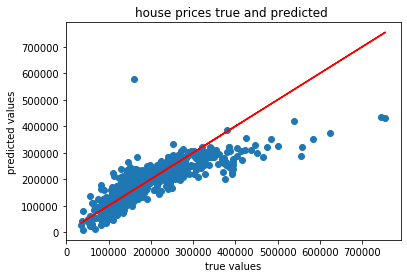

In [113]:
plt.scatter(Y_test,Y_preds_test)
plt.plot(Y_test,Y_test,color='red')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.title('house prices true and predicted ')
plt.show()

In [ ]:
It appears that nearly all of the models might be overfit 